# Convert ERA5 data from GRIB to netCDF
Here we take some GRIB format data sets and convert to netCDF

In [1]:
import warnings
import xarray as xr
import numpy as np
import sys
sys.path.append('/home/users/jamd1/Isca/')
from isca_tools import cesm
from isca_tools.utils import area_weighting, lat_lon_rolling, print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import f90nml
import pandas as pd
import isca_tools
import matplotlib
from matplotlib.dates import ConciseDateConverter
from metpy.calc import specific_humidity_from_dewpoint, relative_humidity_from_dewpoint
import metpy.units
from isca_tools.era5.get_jasmin_era5 import Find_era5
from isca_tools.utils.constants import g
matplotlib.units.registry[cftime.DatetimeNoLeap] = ConciseDateConverter()  # to allow plotting time as x axis
# plt.style.use('/home/users/jamd1/Isca/jobs/publish.mplstyle')
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
from isca_tools.utils.base import split_list_max_n
import os
print(os.getcwd())

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse


In [2]:
# Attempt to load data from JASMIN but very slow - better to download from climate data store
load_from_jasmin = False
if load_from_jasmin:
    lat_loc = [60, 40, -24, 55]
    lon_loc = [50., 355., 133.75, 290.]
    loc_names = ['russia', 'spain', 'australia', 'canada']
    year_use = 1995

    era5 = Find_era5(archive=None)
    var_keep = ['t', 'z', 'q']
    var = era5[var_keep, f"{year_use}-06-01":f"{year_use}-09-01":'3h', None, lat_loc[0]-0.4:lat_loc[0]+0.4, lon_loc[0]-0.4:lon_loc[0]+0.4]     # 2m temperature
# var2 = era5[['t'], "2005-02-01":"2005-02-04", None, 0:3, 0:6]   # log of surface pressure

## Load surface data
Here we load the single level data from the GRIB format

In [3]:
# map of GRIB_shortName
era5_var_map = {
    "10m_u_component_of_wind": "10u",
    "10m_v_component_of_wind": "10v",
    "10m v-component of neutral wind": "v10n",
    "boundary_layer_height": "blh",
    "convective_inhibition": "cin",
    "convective_available_potential_energy": "cape",
    "2m_dewpoint_temperature": "2d",
    "2m_temperature": "2t",
    "volumetric_soil_water_layer_1": "swvl1",
    "convective_precipitation": "cp",
    "total_precipitation": "tp",
    "evaporation": "e",
    "total_cloud_cover": "tcc",
    "cloud_base_height": "cbh",
    "high_cloud_cover": "hcc",
    "low_cloud_cover": "lcc",
    "medium_cloud_cover": "mcc",
    "surface_latent_heat_flux": "slhf",
    "surface_sensible_heat_flux": "sshf",
    "surface_thermal_radiation_downward_clear_sky": "strd",
    "surface_thermal_radiation_downwards": "strd",
    "surface_solar_radiation_downwards": "ssrd",
    "surface_solar_radiation_downward_clear_sky": "ssrdc",
    "surface_net_solar_radiation": "ssr",
    "surface_net_solar_radiation_clear_sky": "ssrc",
    "surface_net_thermal_radiation": "str",
    "surface_net_thermal_radiation_clear_sky": "strc",
    "surface_pressure": "sp",
    "boundary_layer_dissipation": "bld",
    "instantaneous_moisture_flux": "ie"
}

### Convert variables with `step` dimension
Some variables e.g. `cin` have step variable such that `valid_time` to compare to `time_t2m` of 2m temperature say is equal
to `time_cin` + `step`.
Here we make the `time` dimension of all variables match up i.e. change `time` to `valid_time` for variables with `step`.

I think `step` arises because variables are computed over a period of time.

In [4]:
dir_base = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/era5/diurnal_play'
loc = 'canada'
nml_path = f'{dir_base}/{loc}/input_single_lev_local.nml'
grib_vars = f90nml.read(nml_path)['request']['variable']
grib_path_single_lev = f'{dir_base}/{loc}/output_single_level_grib.nc'
times_all = xr.load_dataset(grib_path_single_lev, engine="cfgrib",
                            filter_by_keys={'shortName': '2t'}).time.values  # select times from 2m temperature

In [5]:
def align_var_with_step(var, time_target):
    """
    Align a DataArray 'var' (time_var, step, ...) to a new time_target axis,
    so return 'var_align' (time_target, step, ...).
    Keeps all steps and extra dimensions, fills NaN where valid_time does not exist.

    Parameters
    ----------
    var : xarray.DataArray
        Dims: ('time', 'step', ...) with shape (len(time_var), n_step, ...)
            Contains 2D coordinate 'valid_time' (len(time_var) x n_step)
    time_target : array-like
        Target 1D times to align to.

    Returns
    -------
    out : xarray.DataArray
        Dims: ('time', 'step', ...) with shape (len(time_target), n_step, ...)
        NaNs where no match.
    """
    # Flatten time x step for indexing
    var_flat = var.stack(ts=("time", "step"))
    var_flat = var_flat.transpose('ts', ...)        # make ts first dimension
    valid_time_flat = var_flat.valid_time.values.flatten()  # shape (time*step)

    # Create output coordinates
    coords = {"valid_time": time_target, "step": var.step}
    extra_dims = [d for d in ds.dims if isinstance(d, str) and d not in ("time", "step")]
    for d in extra_dims:
        coords[d] = var.coords[d]

    # Create empty output filled with NaNs
    out_shape = (len(time_target), len(var.step)) + tuple(var.sizes[d] for d in extra_dims)
    out_data = np.full(out_shape, np.nan, dtype=var.dtype)
    out = xr.DataArray(out_data, coords=coords, dims=("valid_time", "step") + tuple(extra_dims))

    # Build mapping from valid_time_flat → time_target index
    time_idx_map = {t: i for i, t in enumerate(time_target)}

    # Map values
    for k, vt in enumerate(valid_time_flat):
        if vt in time_idx_map:
            i = time_idx_map[vt]
            j = k % len(var.step)  # step index
            out[i, j] = var_flat.values[k]  # broadcast over extra dims automatically

    out = out.rename({'valid_time': 'time'})        # rename valid_time as time
    return out

#### Sanity Check
Below we do a sanity check just to make sure the conversion done is correct.

Number of non nan values at lat/lon. Should be the same
Original
 [[32 26 28 24]
 [32 36 28 31]
 [33 36 22 31]
 [33 39 22 23]]
New
 [[32 26 28 24]
 [32 36 28 31]
 [33 36 22 31]
 [33 39 22 23]]


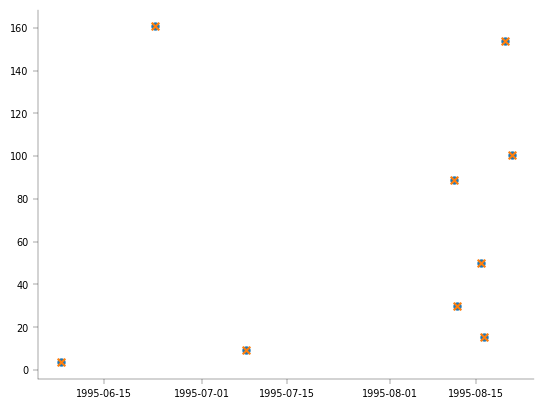

In [6]:
do_sanity_check = True
if do_sanity_check:
    # Sanity check with cin, re indexing variables
    ds = xr.open_dataset(grib_path_single_lev, engine="cfgrib",
                         filter_by_keys={'shortName': 'cin'})
    ds = ds.load()
    ds_new = align_var_with_step(ds.cin, times_all)

    print('Number of non nan values at lat/lon. Should be the same')
    print('Original\n', (~np.isnan(ds.cin)).sum(dim=['time', 'step']).values)
    print('New\n', (~np.isnan(ds_new)).sum(dim=['time', 'step']).values)

    # Make sure new time matches valid time in original raw data
    plt.scatter(ds_new.time, ds_new.isel(latitude=0, longitude=0, step=0), marker='.', s=100)
    plt.scatter(ds.valid_time.isel(step=0), ds.cin.isel(latitude=0, longitude=0, step=0), marker='x', s=30, lw=1.5)

### Combine all variables
For single level data, we have to load each variable individually as can't combine step and non step variables.

In [7]:
ds_all = {}
for var in grib_vars:
    ds = xr.open_dataset(grib_path_single_lev, engine="cfgrib",
                         filter_by_keys={'shortName': era5_var_map[var]})
    if len(ds)==0:
        warnings.warn(f"{var} does not exist")
        # print(ds)
        continue
    name = list(ds.data_vars)[0]
    ds = ds[name]      # convert to dataarray
    if 'step' in ds.dims:
        ds = align_var_with_step(ds, times_all)
    else:
        ds = ds.drop_vars(['step'])
    ds_all[name] = ds

ds_all = xr.Dataset(ds_all)
ds_all = ds_all.drop_vars('valid_time')

## Load in pressure level data

In [8]:
grib_path_pressure = f'{dir_base}/{loc}/output_pressure_grib.nc'
ds_plev = xr.load_dataset(grib_path_pressure, engine="cfgrib")

# rename pressure variable and get rid of step and valid_time
ds_plev = ds_plev.rename_dims({'isobaricInhPa': 'plev'})
ds_plev = ds_plev.rename_vars({'isobaricInhPa': 'plev'})
ds_plev = ds_plev.drop_vars(['step', 'valid_time'])

## Combine and save data as single netCDF
Lastly, we combine the pressure and single level data to output as a single netCDF file.
The lat and lon coordinates are slightly different so we reindex here.

In [9]:
netcdf_path = f'{dir_base}/{loc}/output.nc'
if (loc == 'russia') and (ds_all.latitude.size != ds_plev.latitude.size):
    # Saved one too many latitudes for single level data for russia
    ds_all = ds_all.sel(latitude=ds_plev.latitude, method='nearest')
    print('Got rid of a latitude value for single level data')
# align lat and lon, then combine two datasets
ds_out = xr.merge([ds_all, ds_plev.reindex(latitude=ds_all.latitude, longitude=ds_all.longitude, method="nearest") ])

# Add surface geopotential from invariant (i.e. gz_surf). Use year 2000 as closest I have but should be constant in time
z_surf_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/era5/invariants/z2000.nc'
geopotential_surf = xr.load_dataset(z_surf_path).reindex(latitude=ds_all.latitude, longitude=ds_all.longitude, method="nearest")
ds_out['geopotential_surf'] = geopotential_surf.z
ds_out['geopotential_surf'] = isca_tools.utils.set_attrs(ds_out['geopotential_surf'], True,
                                                         long_name='Geopotential (surface)', standard_name='geopotential_surface')

# Save all data together
ds_out.to_netcdf(netcdf_path)